In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline

In [2]:
def load_MNISTdata():
    """
    Load the MNIST dataset. Reads the training and testing files and create matrices.
    :Expected return:
    train_data:the matrix with the training data
    test_data: the matrix with the data that will be used for testing
    y_train: the matrix consisting of one 
                        hot vectors on each row(ground truth for training)
    y_test: the matrix consisting of one
                        hot vectors on each row(ground truth for testing)
    """
    
    #load the train files
    df = None
    
    y_train = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'mnistdata/train%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_train.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    train_data = df.to_numpy()
    y_train = np.array( y_train )
    
    #load test files
    df = None
    
    y_test = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'mnistdata/train%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_test.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    test_data = df.to_numpy()
    y_test = np.array( y_test )
    
    return train_data, test_data, y_train, y_test

In [3]:
from six.moves import cPickle as pickle

def load_pickle(f):
    return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def get_proper_Ydata(Y):
    K = np.amax(Y) + 1
    N = Y.shape[0]
    properY = np.zeros((N, K))
    for i in range(N):
        clf = Y[i]
        properY[i][clf] = 1
    return properY

def load_CIFAR10(ROOT):
    """
    Load the CIFAR dataset. Reads the training and testing files and create matrices.
    :Expected return:
    Xtrain:the matrix with the training data
    Xtest: the matrix with the data that will be used for testing
    ytrain: the matrix consisting of one 
                        hot vectors on each row(ground truth for training)
    ytest: the matrix consisting of one
                        hot vectors on each row(ground truth for testing)
    """
    xs = []
    ys = []
    for b in range(1,6):
        f = ROOT + 'data_batch_%d' % (b, )
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtrain = np.concatenate(xs)
    Ytrain = np.concatenate(ys)
    del X, Y
    Xtest, Ytest = load_CIFAR_batch(ROOT + 'test_batch')
    return Xtrain, get_proper_Ydata(Ytrain), Xtest, get_proper_Ydata(Ytest)


In [4]:
"""Activation functions and their derivatives for this project."""
def h1(a):
    return np.log(1+np.exp(a))

def h2(a):
    expa = np.exp(a)
    exp_a = np.exp(-a)
    return (expa - exp_a)/ (expa + exp_a)

def h3(a):
    return np.cos(a)

def dh1(a):
    return np.exp(a)/(np.exp(a)+1)

def dh2(a):
    return 1 - np.tanh(a)**2

def dh3(a):
    return -np.sin(a)

In [5]:
def applyFunction(h, x):
    """
    Apply one of the activation functions (or derivatives on an array).
    input: h - function used
           x - array we want to apply the function on
    return: the modified array
    """
    return np.array([h(xi) for xi in x])

def normalize(X_train, X_test):
    """
    Normalize the dataset from pixel values to float.
    input: X_train - X train data array
           X_test - X test data array
    return: tuple (X_train_norm, X_test_norm) of the normalized arrays
    """
    X_train_norm = X_train.astype(float)/255
    X_test_norm = X_test.astype(float)/255
    #try changing astype(float) tp /255.0
    return X_train_norm, X_test_norm

def softmax(x, k):
    """
    Calculates softmax for the k row of given array x.
    input: x - array that we want to use
           k - row of the array (the numerator of the softmax)
    return: float
    """
    #set x_exp as the array with the exponential values of x
    x_exp = np.exp( x )
    return ( x_exp[k] / np.sum(x_exp, axis = 0) )

def calculateNorm(W1, W2):
    """
    Calculates the weight norm, given the 2 weight tables.
    input: W1 - array of weights 1 of dimensions Mx(D+1)
           W2 - array of weights 2 of dimensions Kx(M+1)
    return: float, the calculated norm
    """
    #first we calculate each norm seperately and then sum up the 2 norms
    normW1= np.sum(np.square(W1))
    normW2 = np.sum(np.square(W2))
    return np.sum(np.array([normW1, normW2]))

def initialize(fin, fout):
    """
    Initializes an array of size/shape (fin, fout) using the Glorot distribution.
    input - fin, fout: array dimensions
    return - initialized array W
    """
    glrt = np.sqrt(6/ (fin+ fout))
    W = np.random.uniform(-glrt, glrt, (fin, fout))
    return W

In [6]:
def cost_grad_softmax(W1, W2, X, t, lamda, M, choice):
    """
    Calculates cost and derivatives of weights for the weight update.
    input: W1 - weight array of dimensions Mx(D+1)
           W2 - weight array of dimensions Kx(M+1)
           X  - X data array of dimensions Nx(D+1), where N could be batch size
           t  - t data array of dimensions NxK, likewise
           lamda - the positive regularizarion parameter
           M  - integer which represents the number of hidden units of MLP
           choice - integer (1, 2 or 3) which defines the desired activation function
    return: Cost E - float
            gradEw1 - array of dimensions Mx(D+1)
            gradEw2 - array of dimensions Kx(M+1)
    """
    #z, dz = h(X.dot(w1.T)) -> Nx(M+1)
    #softmax( z.dot(w2.T))
    #initialize cost
    E = 0
    N, D = X.shape
    K = t.shape[1]
    
    #initialize Z and dZ (derivative of Z) arrays
    Z = np.zeros((N, M))
    dZ = np.zeros((N, M))
    
    #calculate the values and fill in the previously mentioned tables
    #for each row/ example of the X array data, using the chosen function
    for n_z in range(N):
        if choice == 1:
            Z[n_z] = applyFunction(h1, np.dot(X[n_z], W1.T))
            dZ[n_z] = applyFunction(dh1, np.dot(X[n_z], W1.T))
        elif choice == 2:
            Z[n_z] = applyFunction(h2, np.dot(X[n_z], W1.T))
            dZ[n_z] = applyFunction(dh2, np.dot(X[n_z], W1.T))
        elif choice == 3:
            Z[n_z] = applyFunction(h3, np.dot(X[n_z], W1.T))
            dZ[n_z] = applyFunction(dh3, np.dot(X[n_z], W1.T))
    #print(Z)
    #print(dZ)
    #add bias column as first column of Z table after the calculation of all the other values
    Z = np.hstack( (np.ones((Z.shape[0], 1)), Z))
    
    #initialize y table and fill it in with the softmax values
    Y = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            Y[n][k] = softmax( np.dot(Z[n],W2.T), k )
            #add tnk*log(ynk) to the cost
            E += t[n][k] * np.log( Y[n][k] )
    
    #substract the lamda*norm/2 from cost
    E -= lamda * calculateNorm(W1, W2) / 2
    
    #calculate the derivatives of each weight table (skipping the bias column of W2 on the W1 calculation
    #                                                so that the arrays can match sizes on calculation)
    gradEw1 = np.dot( (np.multiply( np.dot( (t-Y) , W2[:,1:]), dZ)).T, X) - lamda * W1
    gradEw2 = np.dot( (t-Y).T, Z ) - lamda * W2
    
    return E, gradEw1, gradEw2

In [7]:
def ml_softmax_train(t, X, lamda, Winit1, Winit2, options):
    """inputs :
           t  - t data array of dimensions NxK, likewise
           X  - X data array of dimensions Nx(D+1), where N is the total number of examples
           lamda - the positive regularizarion parameter
           Winit1 - initialized weight array of dimensions Mx(D+1)
           Winit2 - initialized weight array of dimensions Kx(M+1)
      options: options(1) is the maximum number of iterations
               options(2) is the tolerance
               options(3) is the learning rate eta
               options(4) is the batch size
               options(5) is the activation function code choice
    outputs :
      W1: the trained W1 
      W2: the trained W2
      costs: the cost list"""
    
    #shuffle the data by unison
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    t = t[indices]
    
    W1 = Winit1
    W2 = Winit2
    
    # Maximum number of iteration of gradient ascend
    _iter = options[0]

    # Tolerance
    tol = options[1]

    # Learning rate
    eta = options[2]
    
    #batch size
    batch_size = options[3]
    
    #activation function code
    choice = options[4]
    
    #number of hidden units
    M = W1.shape[0]
    
    #initialize the previously calculated cost to - infinity
    Ewold = -np.inf
    
    #initialize costs list
    costs = []
    #for each batch
    for i in range( 0, X.shape[0] , batch_size):
        #calculate cost from grad ascend for slice of the dataset equal to the batch size
        Ew, gradEw1, gradEw2 = cost_grad_softmax(W1, W2, X[i:i+batch_size], t[i:i+batch_size], lamda, M, choice)
        # save cost
        costs.append(Ew)
        # Show the current cost function on screen
        print('Iteration : %d, Cost function :%f' % (i/batch_size + 1, Ew))

        # Break if you achieve the desired accuracy in the cost function
        if np.abs(Ew - Ewold) < tol:
            break
        
        #if maximum number of iterations reached, stop
        _iter = _iter - 1
        if (_iter == 0):
            break
        # Update parameters based on gradient ascend
        W1 = W1 + eta * gradEw1
        W2 = W2 + eta * gradEw2
        Ewold = Ew

    return W1, W2, costs

In [8]:
def gradcheck_softmax(Winit1, Winit2, X, t, lamda, M, choice):
    
    W1 = np.random.rand(*Winit1.shape)
    W2 = np.random.rand(*Winit2.shape)
    epsilon = 1e-6
    
    _list = np.random.randint(X.shape[0], size=5)
    x_sample = np.array(X[_list, :])
    t_sample = np.array(t[_list, :])
    
    Ew, gradEw1, gradEw2 = cost_grad_softmax(W1, W2, x_sample, t_sample, lamda, M, choice)
    
    #print( "gradEw shape: ", gradEw.shape )
    
    numericalGrad1 = np.zeros(gradEw1.shape)
    numericalGrad2 = np.zeros(gradEw2.shape)
    # Compute all numerical gradient estimates and store them in
    # the matrix numericalGrad
    for i in range(numericalGrad1.shape[0]):
        for j in range(numericalGrad1.shape[1]):
            
            #add epsilon to the w[k,d]
            w_tmp1 = np.copy(W1)
            w_tmp2 = np.copy(W2)
            w_tmp1[i, j] += epsilon
            e_plus1, _, _= cost_grad_softmax(w_tmp1, w_tmp2, x_sample, t_sample, lamda, M, choice)

            #subtract epsilon to the w[k,d]
            w_tmp1 = np.copy(W1)
            w_tmp2 = np.copy(W2)
            w_tmp1[i, j] -= epsilon
            e_minus1, _, _ = cost_grad_softmax( w_tmp1, w_tmp2, x_sample, t_sample, lamda, M, choice)
            
            #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
            numericalGrad1[i, j] = (e_plus1 - e_minus1) / (2 * epsilon)
    print("finished w1")        
    for k in range(numericalGrad2.shape[0]):
        for l in range(numericalGrad2.shape[1]):
            
            #add epsilon to the w[k,d]
            w_tmp1 = np.copy(W1)
            w_tmp2 = np.copy(W2)
            w_tmp2[k, l] += epsilon
            e_plus2, _, _= cost_grad_softmax(w_tmp1, w_tmp2, x_sample, t_sample, lamda, M, choice)

            #subtract epsilon to the w[k,d]
            w_tmp1 = np.copy(W1)
            w_tmp2 = np.copy(W2)
            w_tmp2[k, l] -= epsilon
            e_minus2, _, _ = cost_grad_softmax(w_tmp1, w_tmp2, x_sample, t_sample, lamda, M, choice)
            
            #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
            numericalGrad2[k, l] = (e_plus2 - e_minus2) / (2 * epsilon)
    print("finished w2")    
    return ( gradEw1, gradEw2, numericalGrad1, numericalGrad2 )

In [9]:
def ml_softmax_test(W1, W2, X_test, Y_test, K, choice):
    
    if choice == 1:
        ztest = applyFunction(h1, np.dot(X_test, W1.T))
    elif choice == 2:
        ztest = applyFunction(h2, np.dot(X_test, W1.T))
    elif choice == 3:
        ztest = applyFunction(h3, np.dot(X_test, W1.T))
    
    ztest = np.hstack( (np.ones((ztest.shape[0], 1)), ztest))
    
    ytest = np.zeros((X_test.shape[0], K))
    for i in range(X_test.shape[0]):
        for k in range(K):
            ytest[i][k] = softmax( np.dot(ztest[i],W2.T), k )
            
    prediction = np.argmax(ytest, 1)
    return prediction

Run ALL cells above

In [67]:
#run this if you want to get the data from MNIST dataset
X_train, X_test, Y_train, Y_test = load_MNISTdata()

In [31]:
#run this if you want to get the data from CIFAR dataset
X_train, Y_train, X_test, Y_test = load_CIFAR10('cifar-10-batches-py/')

Run the cells bellow to train and predict using the MLP after you've ran ONE of the load data cells

In [68]:
#normalize the data
X_train, X_test = normalize(X_train, X_test)
#set up the parameters
N, D = X_train.shape
K = 10
lamda = 0.01
M = 100
options = [1000, 1e-6, 0.005, 100, 3]
#initialize weights and add bias column to the data
Winit1 = initialize(M, D+1)
Winit2 = initialize(K, M)
Winit2 = np.hstack( (np.ones((Winit2.shape[0], 1)), Winit2))
X_train = np.hstack( (np.ones((X_train.shape[0],1) ), X_train) )
X_test = np.hstack( (np.ones((X_test.shape[0],1) ), X_test) )
#train the MLP
W1, W2, costs = ml_softmax_train(Y_train, X_train, lamda, Winit1, Winit2, options)
#predict
prediction = ml_softmax_test(W1, W2, X_test, Y_test, K ,options[4])
#check accuracy of predictions
print("Accuracy: " + str(np.mean( prediction == np.argmax(Y_test,1))))

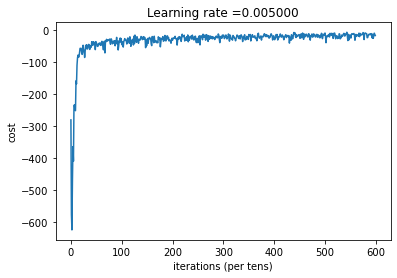

In [66]:
#plot costs by iteration
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(format(options[2], 'f')))
plt.show()

Run the cell bellow to get the difference estimate after you've ran ONE of the load data cells

In [ ]:
gradEw1, gradEw2, numericalGrad1, numericalGrad2 = gradcheck_softmax(Winit1, Winit2, X_train, Y_train, lamda, M, 3)
print( "The difference estimate for gradient of w1 is : ", np.max(np.abs(gradEw1 - numericalGrad1)) )
print( "The difference estimate for gradient of w2 is : ", np.max(np.abs(gradEw2 - numericalGrad2)) )